In [1]:
#import necessary libraries - note uncomment the commented out installed libraries if don't already have
import pandas as pd
import numpy as np
# !pip install openpyxl
import openpyxl
# !pip install statsbombpy
from statsbombpy import sb
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
# !pip install mplsoccer
from mplsoccer import Pitch, VerticalPitch
import matplotlib.patches as mpatches  # For creating legends
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
from mplsoccer import FontManager, Sbopen
import matplotlib.patheffects as path_effects

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 150)

In [7]:
#Read in the dataset that was extracted and transformed in R
womens_pass_data = pd.read_excel('C:\\Users\\kpaul\\Documents\\Univeristy of Glasgow - MSc\\Semester 4 - Fall 2024\\Final Year Project\\Project Code\\womens_pass_data_new.xlsx')
womens_pass_data.head()

,id,match_id,team.name,OpposingTeam,player.name,position.name,play_pattern.name,type.name,minute,second,duration,location.x,location.y,under_pressure,pass.end_location.x,pass.end_location.y,pass.length,pass.angle,pass.recipient.name,pass.height.name,pass.body_part.name,pass.type.name,pass.cross,pass.switch,pass.through_ball,pass.goal_assist,pass.shot_assist,pass.outcome.name,pass.technique.name,teammate_1,fflocation_x_1,fflocation_y_1,teammate_2,fflocation_x_2,fflocation_y_2,teammate_3,fflocation_x_3,fflocation_y_3,teammate_4,fflocation_x_4,fflocation_y_4,teammate_5,fflocation_x_5,fflocation_y_5,teammate_6,fflocation_x_6,fflocation_y_6,teammate_7,fflocation_x_7,fflocation_y_7,teammate_8,fflocation_x_8,fflocation_y_8,teammate_9,fflocation_x_9,fflocation_y_9,teammate_10,fflocation_x_10,fflocation_y_10,teammate_11,fflocation_x_11,fflocation_y_11,teammate_12,fflocation_x_12,fflocation_y_12,teammate_13,fflocation_x_13,fflocation_y_13,teammate_14,fflocation_x_14,fflocation_y_14,teammate_15,fflocation_x_15,fflocation_y_15,teammate_16,fflocation_x_16,fflocation_y_16,teammate_17,fflocation_x_17,fflocation_y_17,teammate_18,fflocation_x_18,fflocation_y_18,teammate_19,fflocation_x_19,fflocation_y_19,teammate_20,fflocation_x_20,fflocation_y_20,teammate_21,fflocation_x_21,fflocation_y_21
0,6a111288-3966-4be5-a4ce-c74e68123652,3893787,New Zealand Women's,Norway Women's,Jacqueline Anne Hand,Right Center Forward,From Kick Off,Pass,0,0,0.6,60.0,40.0,NaN,53.9,36.1,7.2,-2.6,Malia Grace Steinmetz,Ground Pass,Right Foot,Kick Off,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,36.1,49.7,1.0,37.7,36.8,1.0,41.0,67.3,1.0,42.9,21.8,1.0,50.5,47.7,1.0,56.1,36.6,1.0,59.7,52.8,1.0,59.9,13.7,1.0,60.2,70.3,0.0,60.4,50.3,0.0,66.0,28.8,0.0,66.6,50.6,0.0,67.9,19.9,0.0,68.1,60.3,0.0,71.2,40.0,0.0,80.1,60.4,0.0,81.7,34.4,0.0,82.1,25.0,0.0,82.3,49.1,NaN,NaN,NaN,NaN,NaN,NaN
1,a0e65b2e-e7c3-4dfb-829b-7c0a16eac07a,3893787,New Zealand Women's,Norway Women's,Malia Grace Steinmetz,Left Defensive Midfield,From Kick Off,Pass,0,1,1.8,52.8,37.1,NaN,34.1,62.5,31.5,2.2,Catherine Joan Bott,Ground Pass,Right Foot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,34.1,48.9,1.0,35.3,35.2,1.0,37.7,64.5,1.0,43.6,19.6,1.0,49.8,45.6,0.0,54.6,40.5,1.0,58.3,16.1,0.0,61.3,28.6,1.0,62.7,38.4,1.0,63.3,47.9,0.0,64.1,51.5,1.0,65.1,67.8,0.0,66.0,18.7,0.0,68.4,59.3,0.0,68.7,39.4,0.0,79.5,24.5,0.0,80.1,33.9,0.0,82.6,49.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,64d159f6-bb4e-43ad-873d-0f3b902ac84e,3893787,New Zealand Women's,Norway Women's,Catherine Joan Bott,Right Back,From Kick Off,Pass,0,5,2.4,40.1,66.2,NaN,88.9,62.9,48.9,-0.1,Hannah Wilkinson,High Pass,Right Foot,NaN,NaN,NaN,NaN,NaN,NaN,Incomplete,NaN,1,32.4,56.8,1.0,32.5,39.7,0.0,38.8,60.2,1.0,45.2,23.8,1.0,45.7,55.8,0.0,51.4,61.3,0.0,52.5,43.7,0.0,52.6,65.9,1.0,53.5,47.4,0.0,53.6,29.7,0.0,57.6,54.7,1.0,61.1,25.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,e4ecb7bd-4457-4d68-9746-ef1288d68647,3893787,Norway Women's,New Zealand Women's,Mathilde Hauge Harviken,Left Center Back,Regular Play,Pass,0,8,1.3,31.2,17.2,NaN,46.5,11.2,16.4,-0.4,Julie Blakstad,High Pass,Head,Recovery,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,29.6,26.5,1.0,30.5,28.6,1.0,30.6,39.1,0.0,33.2,17.4,1.0,36.9,3.9,0.0,44.1,47.5,1.0,44.4,19.7,0.0,46.5,5.9,0.0,51.3,26.7,1.0,53.7,31.5,1.0,54.2,10.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,507f91c5-f5d2-4435-ac39-12031da38cf2,3893787,Norway Women's,New Zealand Women's,Julie Blakstad,Left Midfield,Regular Play,Pass,0,11,0.3,46.5,7.3,1.0,48.8,6.2,2.5,-0.4,Ada Stolsmo Hegerberg,Ground Pass,Left Foot,NaN,NaN,NaN,NaN,NaN,NaN,Incomplete,NaN,1,24.5,25.2,0.0,25.4,22.4,1.0,28.3,38.9,1.0,29.6,15.3,0.0,30.2,9.4,0.0,33.2,1.6,1.0,38.4,14.8,0.0,42.9,39.1,0.0,46.5,8.8,1.0,47.1,30.0,0.0,47.4,22.2,0.0,49.8,8.3,1.0,50.1,37.5,0.0,51.9,14.9,1.0,55.4,16.9,0.0,55.5,36.9,1.0,59.4,11.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
#Defining a function that cleans up the data to use in exploratory analysis and machine learning models later
def data_clean(df):
    df.drop(['id','type.name'],axis=1,inplace=True) #remove columns
    df = df[~df['position.name'].isin(['Goalkeeper'])] #remove any pass where the player was a goalkeeper
    df = df.assign(time=lambda x: x['minute'].astype(str) + ':' + x['second'].astype(str).str.zfill(2)) #merge the minute and second columns
    df.insert(df.columns.get_loc('minute'), 'time', df.pop('time')) #insert the new time column where the current minute column is
    df.drop(['minute','second'],axis=1,inplace=True) #remove the minute and second columns
    df['under_pressure'] = df['under_pressure'].fillna(0) #fill any NAN with 0 and convert all column values to an int
    df['under_pressure'] = df['under_pressure'].astype(int)
    df = df[~df['pass.type.name'].isin(['Throw-in', 'Free Kick', 'Corner', 'Goal Kick'])] #do not keep passes with the values in isin()
    df['pass.type.name'] = df['pass.type.name'].fillna('Normal')
    df['pass.cross'] = df['pass.cross'].fillna(0) #fill any NAN with 0 and convert all column values to an int
    df['pass.cross'] = df['pass.cross'].astype(int)
    df['pass.switch'] = df['pass.switch'].fillna(0) #fill any NAN with 0 and convert all column values to an int
    df['pass.switch'] = df['pass.switch'].astype(int)
    df['pass.through_ball'] = df['pass.through_ball'].fillna(0) #fill any NAN with 0 and convert all column values to an int
    df['pass.through_ball'] = df['pass.through_ball'].astype(int)
    df['pass.goal_assist'] = df['pass.goal_assist'].fillna(0) #fill any NAN with 0 and convert all column values to an int
    df['pass.goal_assist'] = df['pass.goal_assist'].astype(int)
    df['pass.shot_assist'] = df['pass.shot_assist'].fillna(0) #fill any NAN with 0 and convert all column values to an int
    df['pass.shot_assist'] = df['pass.shot_assist'].astype(int)
    df = df[~df['pass.outcome.name'].isin(['Pass Offside','Injury Clearance'])] #do not keep passes with values in isin()
    df['pass.outcome.name'] = df['pass.outcome.name'].replace(['Incomplete','Out','Unknown'], 0) #replace certain column values with 0
    df['pass.outcome.name'] = df['pass.outcome.name'].fillna(1) # fill any NAN with 1 and convert all column values to int
    df['pass.outcome.name'] = df['pass.outcome.name'].astype(int)
    df['pass.technique.name'] = df['pass.technique.name'].fillna('Unknown') #fill any NAN with unknown

    #This code block renames almost all columns to make the dataframe more clean
    df.rename(columns={
    'team.name': 'team_name', 'OpposingTeam': 'opposing_team', 'player.name': 'player_name', 'position.name': 'poistion',
    'play_pattern.name': 'play_pattern', 'location.x': 'passer_loc_x','location.y': 'passer_loc_y', 'pass.end_location.x': 'pass_end_x',
    'pass.end_location.y': 'pass_end_y', 'pass.length': 'pass_length', 'pass.angle': 'pass_angle','pass.recipient.name': 'pass_recipient', 'pass.height.name': 'pass_height_name',
    'pass.body_part.name': 'pass_body_part', 'pass.type.name': 'pass_type', 'pass.cross': 'pass_cross', 'pass.switch': 'pass_switch', 'pass.through_ball':'pass_through_ball',
    'pass.goal_assist':'pass_goal_assist','pass.shot_assist': 'pass_shot_assist','pass.outcome.name': 'pass_outcome', 'pass.technique.name': 'pass_technique', 'teammate_1': 'player1',
    'fflocation_x_1': 'player1_x', 'fflocation_y_1': 'player1_y', 'teammate_2': 'player2','fflocation_x_2': 'player2_x','fflocation_y_2': 'player2_y',
    'teammate_3': 'player3','fflocation_x_3': 'player3_x', 'fflocation_y_3': 'player3_y', 'teammate_4': 'player4','fflocation_x_4': 'player4_x','fflocation_y_4': 'player4_y',
    'teammate_5': 'player5','fflocation_x_5': 'player5_x', 'fflocation_y_5': 'player5_y', 'teammate_6': 'player6','fflocation_x_6': 'player6_x','fflocation_y_6': 'player6_y',
    'teammate_7': 'player7','fflocation_x_7': 'player7_x', 'fflocation_y_7': 'player7_y','teammate_8': 'player8','fflocation_x_8': 'player8_x','fflocation_y_8': 'player8_y',
    'teammate_9': 'player9','fflocation_x_9': 'player9_x', 'fflocation_y_9': 'player9_y', 'teammate_10': 'player10','fflocation_x_10': 'player10_x','fflocation_y_10': 'player10_y',
    'teammate_11': 'player11','fflocation_x_11': 'player11_x', 'fflocation_y_11': 'player11_y', 'teammate_12': 'player12','fflocation_x_12': 'player12_x','fflocation_y_12': 'player12_y',
    'teammate_13': 'player13','fflocation_x_13': 'player13_x', 'fflocation_y_13': 'player13_y','teammate_14': 'player14','fflocation_x_14': 'player14_x','fflocation_y_14': 'player14_y',
    'teammate_15': 'player15','fflocation_x_15': 'player15_x', 'fflocation_y_15': 'player15_y','teammate_16': 'player16','fflocation_x_16': 'player16_x','fflocation_y_16': 'player16_y',
    'teammate_17': 'player17','fflocation_x_17': 'player17_x', 'fflocation_y_17': 'player17_y', 'teammate_18': 'player18','fflocation_x_18': 'player18_x','fflocation_y_18': 'player18_y',
    'teammate_19': 'player19','fflocation_x_19': 'player19_x', 'fflocation_y_19': 'player19_y', 'teammate_20': 'player20','fflocation_x_20': 'player20_x','fflocation_y_20': 'player20_y',
    'teammate_21': 'player21','fflocation_x_21': 'player21_x','fflocation_y_21': 'player21_y'
    }, inplace=True)

    #Convert all other player columns to have 0 filled for NAN and the column values become int. This will give values of 0 or 1 in the column.
    cols_convert_teammate = ['player1', 'player2', 'player3', 'player4', 'player5', 'player6', 'player7', 'player8', 'player9', 'player10',
                       'player11', 'player12', 'player13', 'player14', 'player15', 'player16', 'player17', 'player18', 'player19',
                       'player20', 'player21']
    df[cols_convert_teammate] = df[cols_convert_teammate].fillna(0).astype(int)

    #For all other player columns (the x and y columns) group them and fill any NAN with 0 (any player that is not in the frame will be placed at 0,0).
    cols_convert_player_loc = ['player1_x', 'player2_x', 'player3_x', 'player4_x', 'player5_x', 'player6_x', 'player7_x', 'player8_x', 'player9_x',
                               'player10_x','player11_x', 'player12_x', 'player13_x', 'player14_x', 'player15_x', 'player16_x', 'player17_x',
                               'player18_x', 'player19_x','player20_x', 'player21_x','player1_y', 'player2_y', 'player3_y', 'player4_y', 'player5_y',
                               'player6_y', 'player7_y', 'player8_y', 'player9_y','player10_y','player11_y', 'player12_y', 'player13_y', 'player14_y',
                               'player15_y', 'player16_y', 'player17_y','player18_y', 'player19_y','player20_y', 'player21_y']
    df[cols_convert_player_loc] = df[cols_convert_player_loc].fillna(0)
    
    return df


    

In [11]:
#apply function to dataframe and display it to check the output
clean_womens_pass_data = data_clean(womens_pass_data)
display(clean_womens_pass_data)

,match_id,team_name,opposing_team,player_name,poistion,play_pattern,time,duration,passer_loc_x,passer_loc_y,under_pressure,pass_end_x,pass_end_y,pass_length,pass_angle,pass_recipient,pass_height_name,pass_body_part,pass_type,pass_cross,pass_switch,pass_through_ball,pass_goal_assist,pass_shot_assist,pass_outcome,pass_technique,player1,player1_x,player1_y,player2,player2_x,player2_y,player3,player3_x,player3_y,player4,player4_x,player4_y,player5,player5_x,player5_y,player6,player6_x,player6_y,player7,player7_x,player7_y,player8,player8_x,player8_y,player9,player9_x,player9_y,player10,player10_x,player10_y,player11,player11_x,player11_y,player12,player12_x,player12_y,player13,player13_x,player13_y,player14,player14_x,player14_y,player15,player15_x,player15_y,player16,player16_x,player16_y,player17,player17_x,player17_y,player18,player18_x,player18_y,player19,player19_x,player19_y,player20,player20_x,player20_y,player21,player21_x,player21_y
0,3893787,New Zealand Women's,Norway Women's,Jacqueline Anne Hand,Right Center Forward,From Kick Off,0:00,0.6,60.0,40.0,0,53.9,36.1,7.2,-2.6,Malia Grace Steinmetz,Ground Pass,Right Foot,Kick Off,0,0,0,0,0,1,Unknown,1,36.1,49.7,1,37.7,36.8,1,41.0,67.3,1,42.9,21.8,1,50.5,47.7,1,56.1,36.6,1,59.7,52.8,1,59.9,13.7,1,60.2,70.3,0,60.4,50.3,0,66.0,28.8,0,66.6,50.6,0,67.9,19.9,0,68.1,60.3,0,71.2,40.0,0,80.1,60.4,0,81.7,34.4,0,82.1,25.0,0,82.3,49.1,0,0.0,0.0,0,0.0,0.0
1,3893787,New Zealand Women's,Norway Women's,Malia Grace Steinmetz,Left Defensive Midfield,From Kick Off,0:01,1.8,52.8,37.1,0,34.1,62.5,31.5,2.2,Catherine Joan Bott,Ground Pass,Right Foot,Normal,0,0,0,0,0,1,Unknown,1,34.1,48.9,1,35.3,35.2,1,37.7,64.5,1,43.6,19.6,1,49.8,45.6,0,54.6,40.5,1,58.3,16.1,0,61.3,28.6,1,62.7,38.4,1,63.3,47.9,0,64.1,51.5,1,65.1,67.8,0,66.0,18.7,0,68.4,59.3,0,68.7,39.4,0,79.5,24.5,0,80.1,33.9,0,82.6,49.1,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
2,3893787,New Zealand Women's,Norway Women's,Catherine Joan Bott,Right Back,From Kick Off,0:05,2.4,40.1,66.2,0,88.9,62.9,48.9,-0.1,Hannah Wilkinson,High Pass,Right Foot,Normal,0,0,0,0,0,0,Unknown,1,32.4,56.8,1,32.5,39.7,0,38.8,60.2,1,45.2,23.8,1,45.7,55.8,0,51.4,61.3,0,52.5,43.7,0,52.6,65.9,1,53.5,47.4,0,53.6,29.7,0,57.6,54.7,1,61.1,25.7,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
3,3893787,Norway Women's,New Zealand Women's,Mathilde Hauge Harviken,Left Center Back,Regular Play,0:08,1.3,31.2,17.2,0,46.5,11.2,16.4,-0.4,Julie Blakstad,High Pass,Head,Recovery,0,0,0,0,0,1,Unknown,0,29.6,26.5,1,30.5,28.6,1,30.6,39.1,0,33.2,17.4,1,36.9,3.9,0,44.1,47.5,1,44.4,19.7,0,46.5,5.9,0,51.3,26.7,1,53.7,31.5,1,54.2,10.1,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
4,3893787,Norway Women's,New Zealand Women's,Julie Blakstad,Left Midfield,Regular Play,0:11,0.3,46.5,7.3,1,48.8,6.2,2.5,-0.4,Ada Stolsmo Hegerberg,Ground Pass,Left Foot,Normal,0,0,0,0,0,0,Unknown,1,24.5,25.2,0,25.4,22.4,1,28.3,38.9,1,29.6,15.3,0,30.2,9.4,0,33.2,1.6,1,38.4,14.8,0,42.9,39.1,0,46.5,8.8,1,47.1,30.0,0,47.4,22.2,0,49.8,8.3,1,50.1,37.5,0,51.9,14.9,1,55.4,16.9,0,55.5,36.9,1,59.4,11.9,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51591,3906390,Spain Women's,England Women's,Irene Paredes Hernandez,Left Center Back,Regular Play,101:53,1.2,29.5,21.7,0,31.3,14.9,7.0,-1.3,Olga Carmona García,Ground Pass,Left Foot,Recovery,0,0,0,0,0,1,Unknown,1,6.3,39.1,0,28.6,18.6,1,29.6,37.1,1,30.9,41.0,0,31.6,38.8,1,33.3,22.7,1,36.1,12.1,0,36.9,31.7,0,37.6,11.9,1,39.2,32.6,0,39.6,50.8,1,39.7,19.4,0,44.6,18.3,1,44.7,38.3,1,48.1,14.1,0,48.4,12.1,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
51592,3906390,Spa

In [11]:
# #Create excel out of transformed data - use dataset for ML models and SNA
# clean_womens_pass_data.to_excel("C:\\Users\\kpaul\\Documents\\Univeristy of Glasgow - MSc\\Semester 4 - Fall 2024\\Final Year Project\\Project Code\\pass_data_modelling.xlsx")  

# EXPLORATORY DATA ANALYSIS

In [13]:
#Creating a function that will calculate each teams passing accuracy (%)
def calc_team_passing_accuracy(df):
    #Group by team and calculate total and successful passes
    accuracy_df = df.groupby('team_name').agg(
        all_passes=('pass_outcome', 'size'), #take the size of column pass_outcome
        completed_passes=('pass_outcome', 'sum')).reset_index() #pass_outcome has values of 0 and 1, calc sum to find # of completed passes 
    #Calculate passing accuracy
    accuracy_df['passing_accuracy'] = round((accuracy_df['completed_passes'] / accuracy_df['all_passes']) * 100,1)
    return accuracy_df[['team_name', 'passing_accuracy']]

#Apply function and assign to new df
team_accuracy = calc_team_passing_accuracy(clean_womens_pass_data)
team_accuracy.sort_values(by='passing_accuracy', ascending=False).head(10)

,team_name,passing_accuracy
26,Spain Women's,83.5
8,England Women's,83.4
10,Germany Women's,81.4
17,Netherlands Women's,80.0
28,Switzerland Women's,79.7
14,Japan Women's,79.2
20,Norway Women's,77.9
3,Canada Women's,77.8
2,Brazil Women's,76.6
9,France Women's,76.6


In [15]:
#Creating a function that will calculate each players overall passing accuracy (%)
def calc_player_passing_accuracy(df):
    #Group by player,team, and position to calculate total and successful passes
    accuracy_df = df.groupby(['player_name','team_name','poistion']).agg(
        all_passes=('pass_outcome', 'size'),
        completed_passes=('pass_outcome', 'sum'),
        num_matches=('match_id', 'nunique')).reset_index() #calc number of matches for each player
    #Calculate passing accuracy
    accuracy_df['passing_accuracy'] = round((accuracy_df['completed_passes'] / accuracy_df['all_passes']) * 100,1)
    #Only keep players that made greater than 75 passes and played 3 or more games
    accuracy_df = accuracy_df[(accuracy_df['all_passes'] > 75) & (accuracy_df['num_matches']>=3)]
    return accuracy_df[['player_name', 'team_name', 'poistion', 'passing_accuracy']]

#Apply function and assign to a new df
player_accuracy = calc_player_passing_accuracy(clean_womens_pass_data)
player_accuracy.sort_values(by='passing_accuracy', ascending=False).head(10)

,player_name,team_name,poistion,passing_accuracy
287,Elena Linari,Italy Women's,Right Center Back,93.8
834,Millie Bright,England Women's,Center Back,91.7
753,Maren Nævdal Mjelde,Norway Women's,Right Center Back,91.2
644,Laia Codina Panedas,Spain Women's,Left Center Back,91.0
612,Keira Walsh,England Women's,Center Defensive Midfield,90.5
531,Jill Roord,Netherlands Women's,Right Center Midfield,90.3
29,Alex Greenwood,England Women's,Left Center Back,90.1
299,Ella Toone,England Women's,Left Center Midfield,89.8
976,Saki Kumagai,Japan Women's,Center Back,89.8
884,Ona Batlle Pascual,Spain Women's,Left Back,89.3


In [17]:
#Calculate the percentage of complete vs incomplete passes (for entire dataset)
complete_passes = clean_womens_pass_data[clean_womens_pass_data['pass_outcome'] == 1].shape[0]
incomplete_passes = clean_womens_pass_data[clean_womens_pass_data['pass_outcome'] != 1].shape[0]
total = complete_passes + incomplete_passes

complete_percentage = (complete_passes / total) * 100
incomplete_percentage = (incomplete_passes / total) * 100
print(f"Percentage of complete passes: {complete_percentage:.2f}%")
print(f"Percentage of incomplete passes: {incomplete_percentage:.2f}%")


Percentage of complete passes: 75.12%
Percentage of incomplete passes: 24.88%


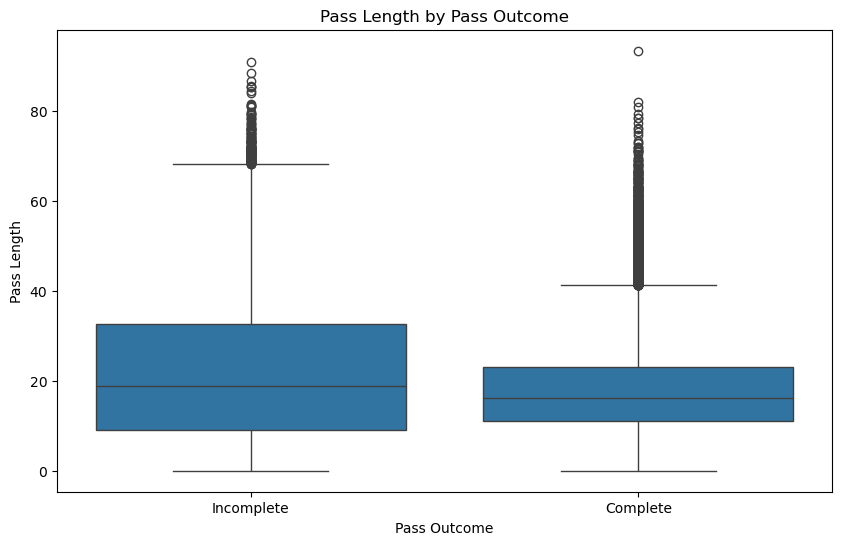

In [19]:
#Box plot to observe relationship between pass length and pass outcome
plt.figure(figsize=(10, 6))
sns.boxplot(x='pass_outcome', y='pass_length', data=clean_womens_pass_data)
plt.xlabel('Pass Outcome')
plt.ylabel('Pass Length')
plt.title('Pass Length by Pass Outcome')
plt.xticks([0, 1], ['Incomplete', 'Complete'])
plt.show()


In [21]:
#The next few coding cells will go through correlation between columns. Since there are a ton of columns and categorical variables in some,
#the columns were spilt up

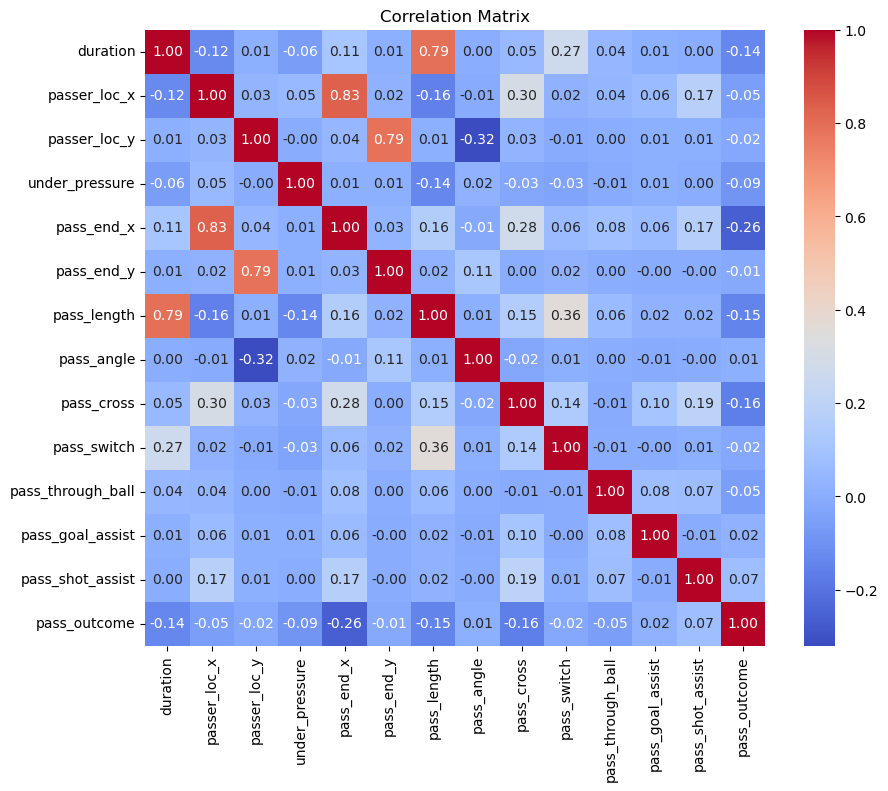

In [27]:
#Checking the correlation between the columns selected
correlation_columns = [
    'duration', 'passer_loc_x', 'passer_loc_y', 'under_pressure',
    'pass_end_x', 'pass_end_y', 'pass_length', 'pass_angle',
    'pass_cross', 'pass_switch', 'pass_through_ball',
    'pass_goal_assist', 'pass_shot_assist', 'pass_outcome']
#Selecting the specified columns
correlation_df_1 = clean_womens_pass_data[correlation_columns]
#Calculating correlation matrix
correlation_matrix = correlation_df_1.corr()

#Plot correlation values
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

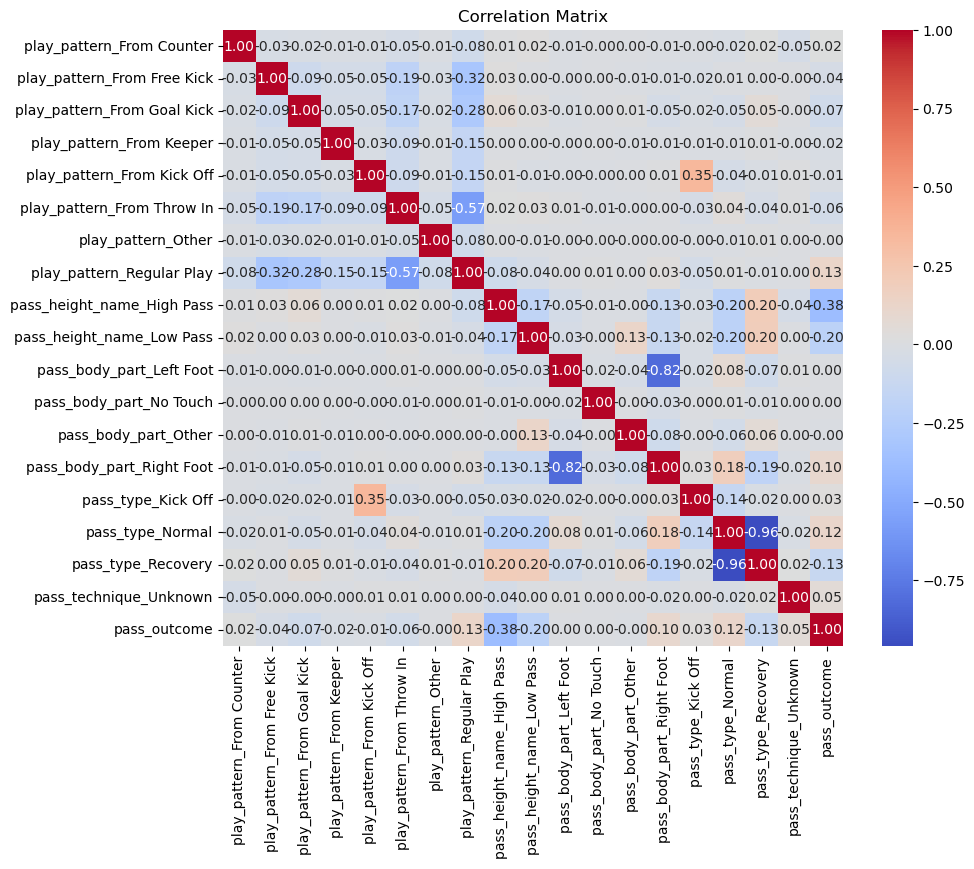

In [29]:
#One-hot encoding for categorical variables
categorical_columns = ['play_pattern', 'pass_height_name','pass_body_part', 'pass_type', 'pass_technique']
correlation_df_2 = pd.get_dummies(clean_womens_pass_data[categorical_columns], drop_first=True)

#Create df of just pass_outcome (not included before as it is not categorical)
correlation_df_outcome = clean_womens_pass_data['pass_outcome']
#Merge dfs
merge_corr = pd.concat([correlation_df_2, correlation_df_outcome], axis=1)

#Calculating the correlation matrix
correlation_matrix_1 = merge_corr.corr()
#Plot correlation values
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_1, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

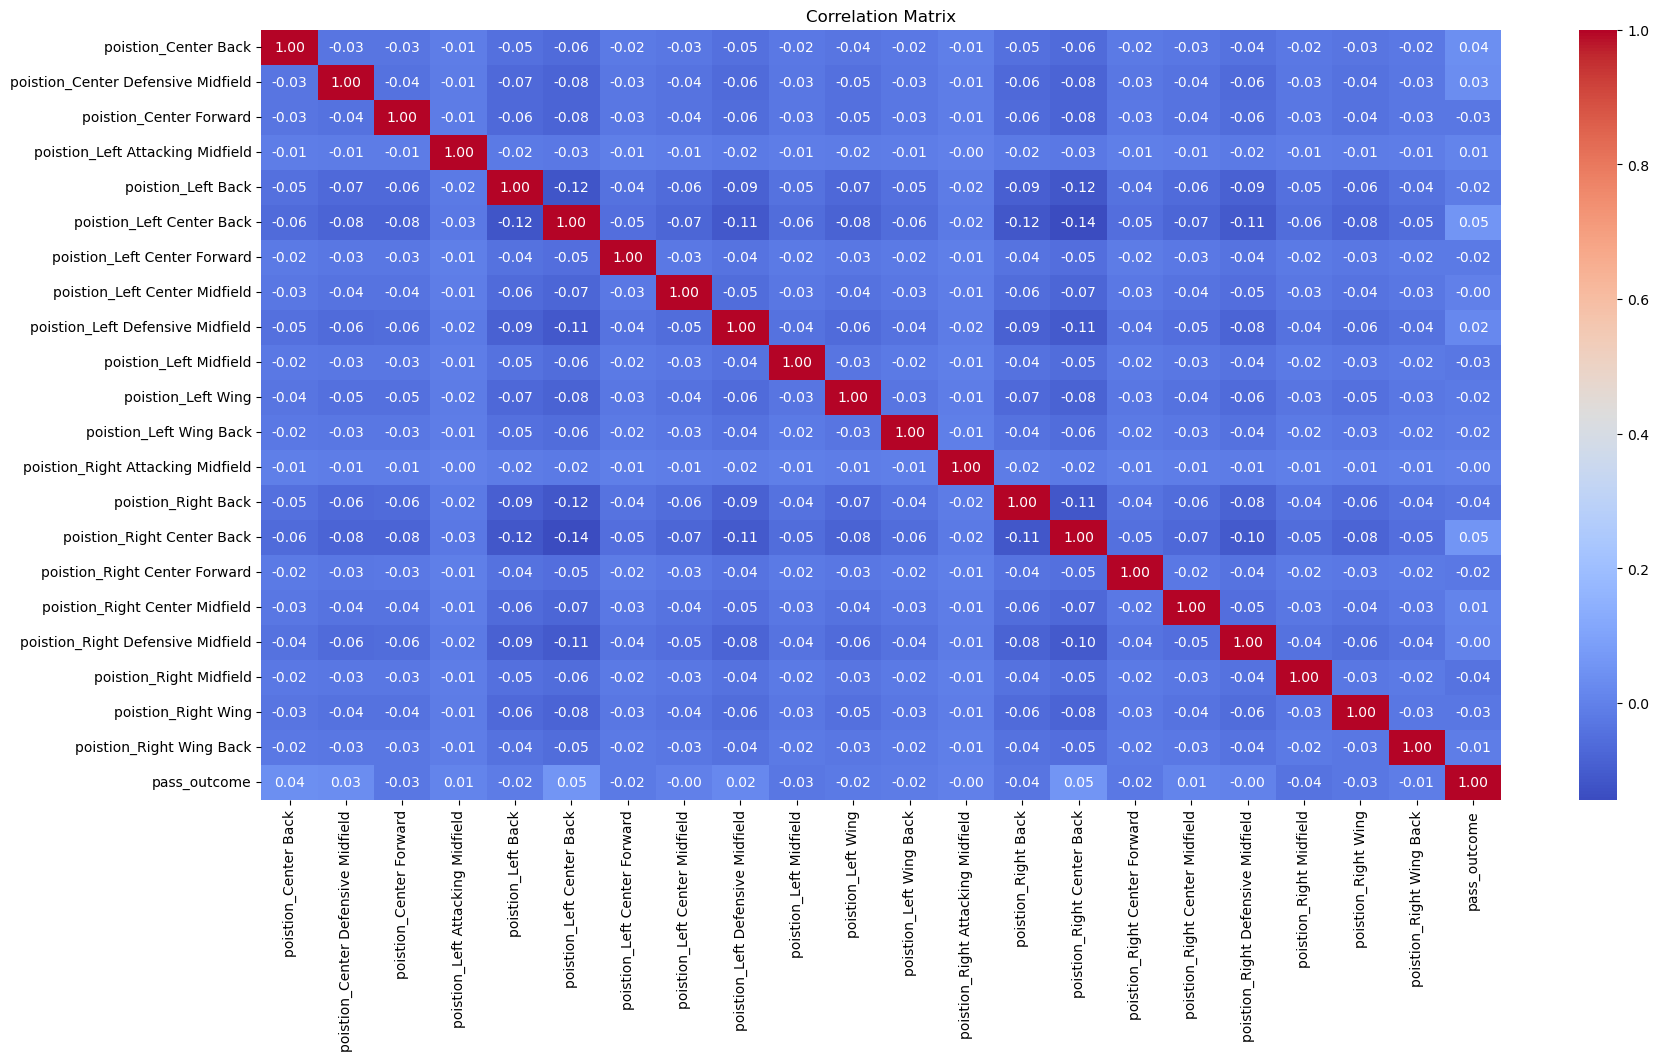

In [31]:
#One-hot encoding for 'position' column
categorical_columns_1 = ['poistion']
correlation_df_3 = pd.get_dummies(clean_womens_pass_data[categorical_columns_1], drop_first=True)

#Merge the position df with outcome column
merge_corr = pd.concat([correlation_df_3, correlation_df_outcome], axis=1)

#Calculating correlation matrix
correlation_matrix = merge_corr.corr()
#Plot correlation values 
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [33]:
#Create a filtered dataframe to do some exploratory analysis on spain vs costa rica game
eda_spain_womens = clean_womens_pass_data[(clean_womens_pass_data['team_name']=="Spain Women's") & (clean_womens_pass_data['match_id']== 3893791)]
eda_spain_womens.head()

,match_id,team_name,opposing_team,player_name,poistion,play_pattern,time,duration,passer_loc_x,passer_loc_y,under_pressure,pass_end_x,pass_end_y,pass_length,pass_angle,pass_recipient,pass_height_name,pass_body_part,pass_type,pass_cross,pass_switch,pass_through_ball,pass_goal_assist,pass_shot_assist,pass_outcome,pass_technique,player1,player1_x,player1_y,player2,player2_x,player2_y,player3,player3_x,player3_y,player4,player4_x,player4_y,player5,player5_x,player5_y,player6,player6_x,player6_y,player7,player7_x,player7_y,player8,player8_x,player8_y,player9,player9_x,player9_y,player10,player10_x,player10_y,player11,player11_x,player11_y,player12,player12_x,player12_y,player13,player13_x,player13_y,player14,player14_x,player14_y,player15,player15_x,player15_y,player16,player16_x,player16_y,player17,player17_x,player17_y,player18,player18_x,player18_y,player19,player19_x,player19_y,player20,player20_x,player20_y,player21,player21_x,player21_y
3015,3893791,Spain Women's,Costa Rica Women's,Esther Gonzalez Rodríguez,Center Forward,From Kick Off,0:01,1.0,61.0,40.1,0,42.0,40.4,19.0,3.1,Teresa Abelleira Dueñas,Ground Pass,Right Foot,Kick Off,0,0,0,0,0,1,Unknown,1,45.6,59.9,1,46.7,38.6,1,48.8,46.1,1,57.0,25.7,1,60.0,12.0,1,60.1,71.5,0,60.9,29.4,0,65.2,57.9,0,67.6,24.5,0,73.8,42.8,0,76.0,37.7,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
3016,3893791,Spain Women's,Costa Rica Women's,Teresa Abelleira Dueñas,Center Defensive Midfield,From Kick Off,0:02,1.0,44.3,40.5,0,47.7,51.7,11.7,1.3,Aitana Bonmati Conca,Ground Pass,Left Foot,Normal,0,0,0,0,0,1,Unknown,1,35.3,46.9,1,44.7,62.9,1,45.8,48.7,0,55.1,34.0,1,57.5,26.0,1,60.6,10.0,1,60.8,73.8,0,61.7,27.0,1,63.3,39.5,0,63.9,56.8,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
3017,3893791,Spain Women's,Costa Rica Women's,Aitana Bonmati Conca,Right Center Midfield,From Kick Off,0:05,1.8,52.6,55.7,0,53.0,67.5,11.8,1.5,Ona Batlle Pascual,Ground Pass,Left Foot,Normal,0,0,0,0,0,1,Unknown,1,50.0,39.4,1,51.8,68.6,0,60.4,47.5,1,64.7,28.4,0,65.7,35.2,0,68.6,62.0,1,71.0,79.2,0,71.6,52.4,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
3018,3893791,Spain Women's,Costa Rica Women's,Ona Batlle Pascual,Right Back,From Kick Off,0:08,1.8,53.9,68.1,0,53.5,42.5,25.6,-1.6,Teresa Abelleira Dueñas,Ground Pass,Right Foot,Normal,0,0,0,0,0,1,Unknown,1,52.2,45.1,0,61.6,58.6,1,62.1,65.9,0,65.3,71.4,1,66.1,29.5,1,66.4,84.5,0,68.3,45.3,0,69.9,63.4,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
3019,3893791,Spain Women's,Costa Rica Women's,Teresa Abelleira Dueñas,Center Defensive Midfield,From Kick Off,0:11,1.3,56.8,40.8,0,71.8,18.9,26.5,-1.0,Jennifer Hermoso Fuentes,Ground Pass,Right Foot,Normal,0,0,0,0,0,1,Unknown,1,49.0,50.8,1,58.1,66.1,0,63.5,43.7,0,67.1,33.1,1,68.0,24.5,0,70.1,58.8,0,72.1,42.7,0,72.4,49.7,1,73.7,60.5,1,78.2,78.5,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0


In [35]:
#Make starting and end pass locations, and pass outcome columns into lists to use in pitch visuals
start_x = eda_spain_womens['passer_loc_x'].tolist()
start_y = eda_spain_womens['passer_loc_y'].tolist()
end_x = eda_spain_womens['pass_end_x'].tolist()
end_y = eda_spain_womens['pass_end_y'].tolist()
pass_outcomes = eda_spain_womens['pass_outcome'].tolist()

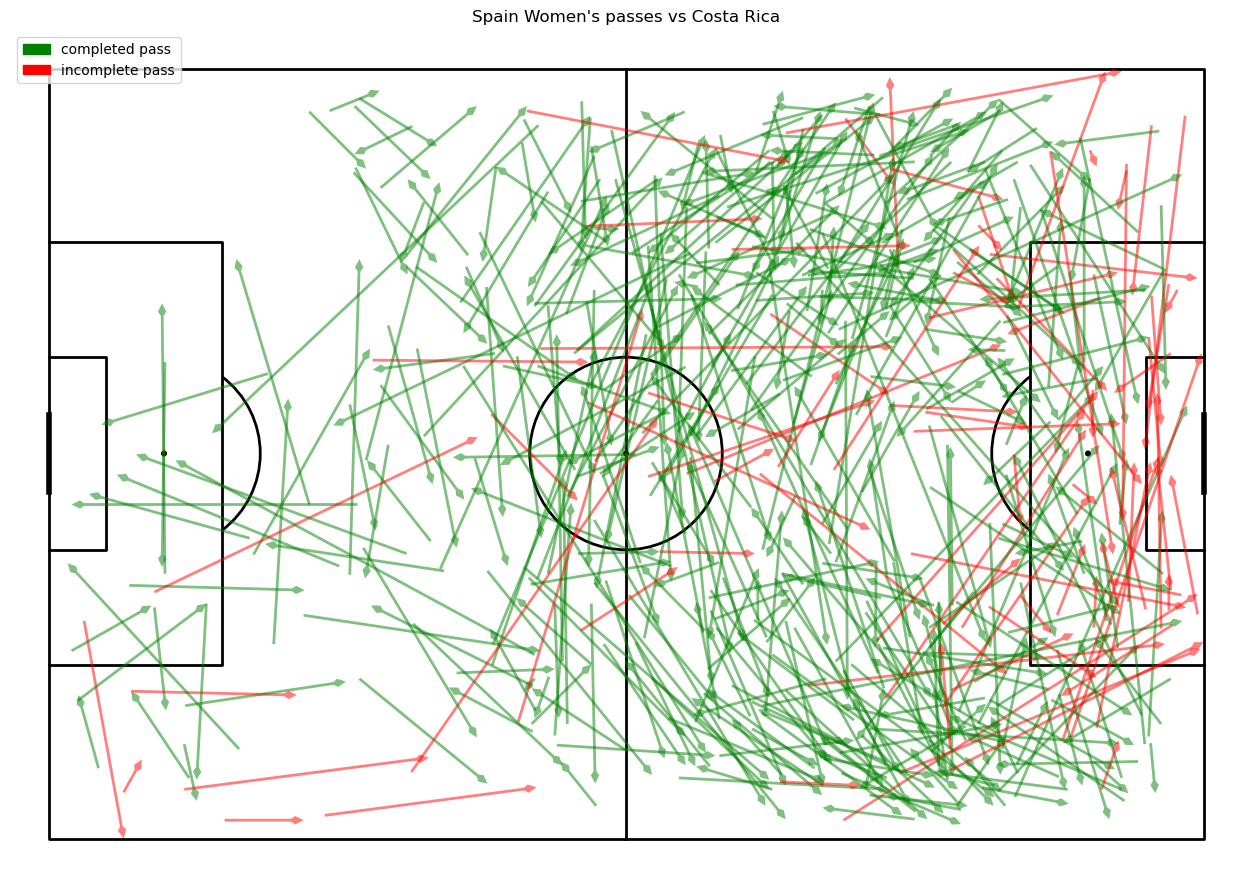

In [41]:
#Create the pitch, choose colors and etc
pitch = Pitch(pitch_type='statsbomb', pitch_color='white', line_color='black')
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)
fig.set_facecolor('white')
colors = ['green' if outcome == 1 else 'red' for outcome in pass_outcomes] #color code the complete vs incomplete passes

#Create the arrows that indicate the pass start, end and direction
pitch.arrows(start_x, start_y, end_x, end_y, width=2, headwidth=3, headlength=3, color=colors, ax=ax, alpha=0.5) 

#Add legend to the pitch
legend_handles = [
    mpatches.Patch(color='green', label='completed pass'),
    mpatches.Patch(color='red', label='incomplete pass')]
ax.legend(handles=legend_handles, loc='upper left')
ax.set_title("Spain Women's passes vs Costa Rica")
plt.show()

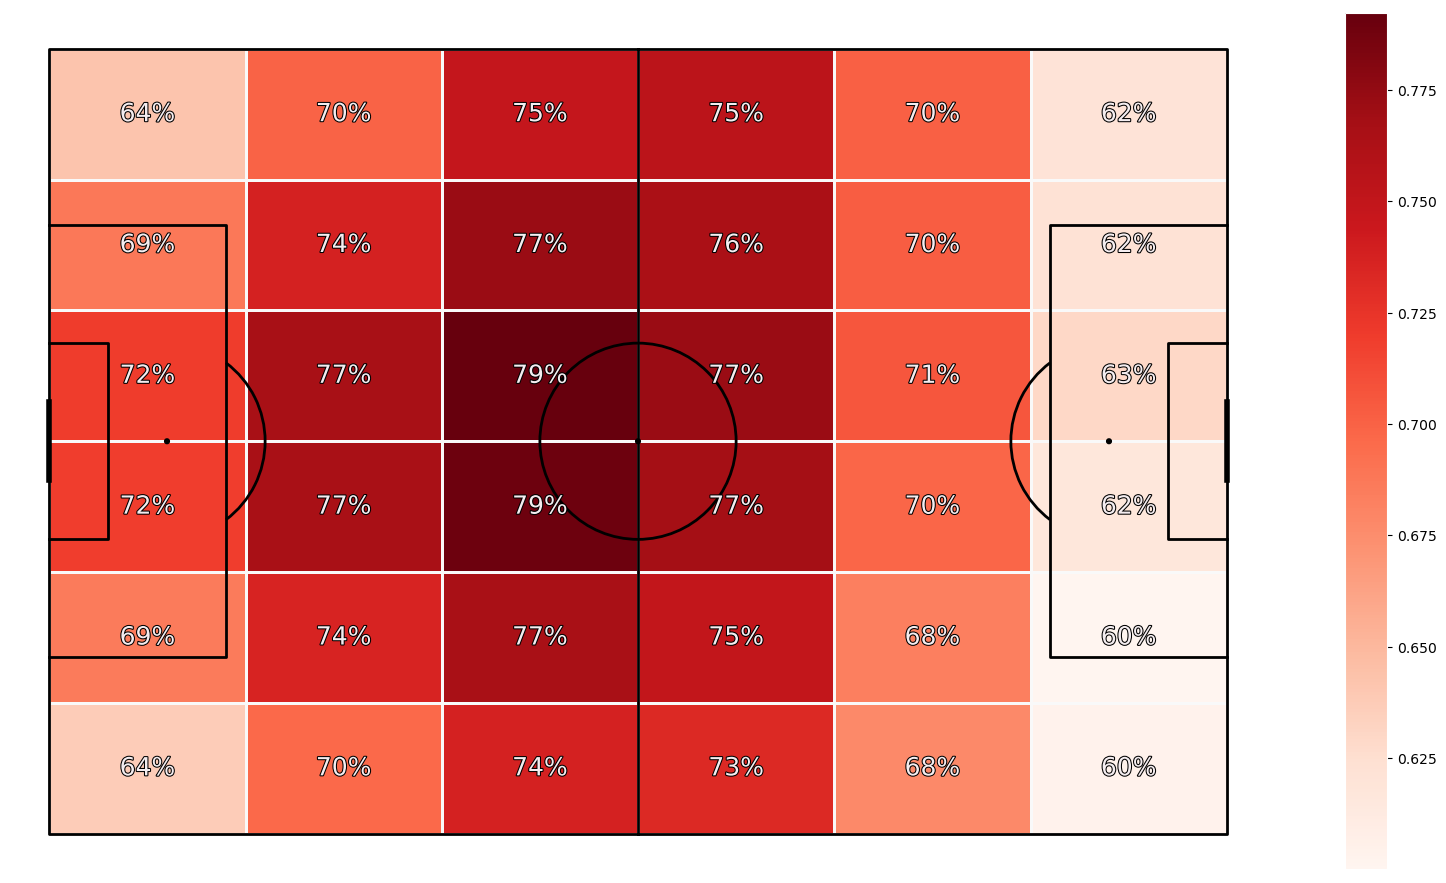

In [43]:
#setup pitch again
pitch_1 = Pitch(pitch_type='statsbomb', line_zorder=2, pitch_color='white', line_color='black')
fig_1, ax_1 = pitch_1.draw(figsize=(16,11))
fig_1.set_facecolor('white')

#Create visual of pitch divided into sections to see where pass completion was highest
#Use bin_statistic to count total and completed passes
bin_statistic = pitch.bin_statistic(
    clean_womens_pass_data['passer_loc_x'],
    clean_womens_pass_data['passer_loc_y'],
    statistic='count',
    bins=(6, 6) #spilt the field into 36 equal areas
)
#Count completed passes
completed_statistic = pitch.bin_statistic(
    clean_womens_pass_data['passer_loc_x'],
    clean_womens_pass_data['passer_loc_y'],
    values=clean_womens_pass_data['pass_outcome'],
    statistic='sum',  #sum the completed passes
    bins=(6, 6)
)

#Calculate percentage of completed passes
percentage_completed = (completed_statistic['statistic'] / bin_statistic['statistic'])
percentage_completed[bin_statistic['statistic'] == 0] = 0  #division by zero
#Apply Gaussian filter - smooth data and reduce noise
percentage_completed = gaussian_filter(percentage_completed, 1)
#Update the bin_statistic to include the percentage (for each section on pitch)
bin_statistic['statistic'] = percentage_completed

#Choose colors and add color legend on side
pcm = pitch_1.heatmap(bin_statistic, ax=ax_1, cmap='Reds', edgecolor='#f9f9f9')
cbar = fig_1.colorbar(pcm, ax=ax_1, shrink=0.8)
cbar.outline.set_edgecolor('white')
cbar.ax.yaxis.set_tick_params(color='black')
ticks = plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='black')

#Custom font for visual
robotto_regular = FontManager()
#Background effects for better visbility
path_eff = [path_effects.Stroke(linewidth=1.5, foreground='black'),
            path_effects.Normal()]
#Put percentage of pass completion in correct section of pitch
labels2 = pitch_1.label_heatmap(bin_statistic, color='#f4edf0', fontsize=18,
                              ax=ax_1, ha='center', va='center',
                              str_format='{:.0%}', path_effects=path_eff)